In [1]:
import sys
sys.path.append("../")

# Get rid of annoying tf warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
from scipy.stats import beta, expon

from models import RandomWalkPoissonModel
from experiments import NeuralCoalMiningExperiment, BayesLoopCoalMiningExperiment
from data import coal_mining_data

../../../../BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [31]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = False
RUN_BAYESLOOP = False

# Neural Experiment

In [2]:
model = RandomWalkPoissonModel()

INFO:root:Performing 2 pilot runs with the poisson_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [3]:
neural_experiment = NeuralCoalMiningExperiment(model)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [20]:
if TRAIN_NETWORKS:
    history = neural_experiment.run(
        epochs=20, 
        iterations_per_epoch=1000, 
        batch_size=32
    )
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

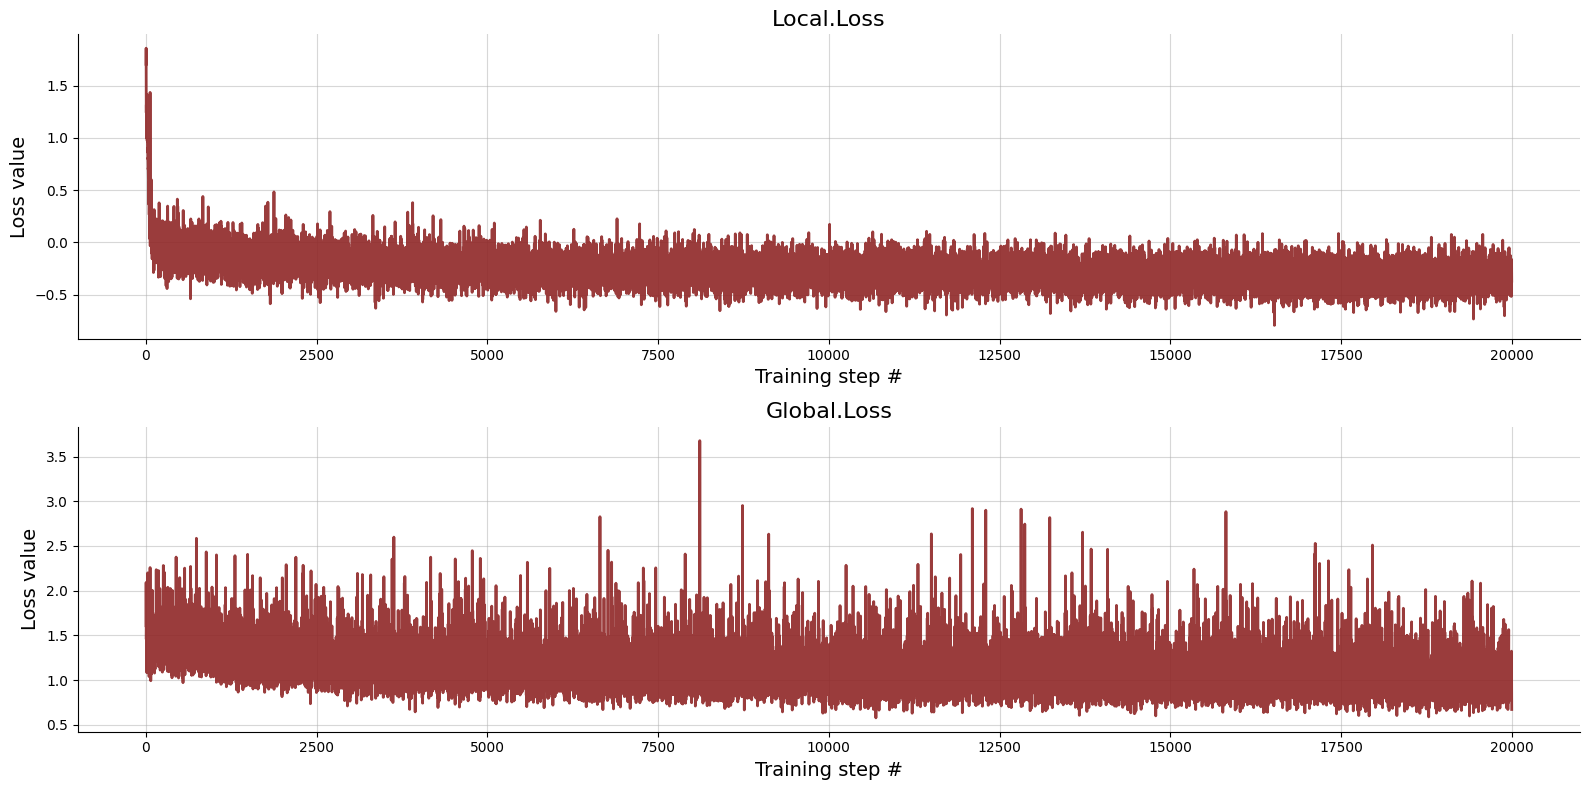

In [22]:
f = beef.diagnostics.plot_losses(history)

# BayesLoop Experiment

In [23]:
bayesloop_experiment = BayesLoopCoalMiningExperiment()

+ Created new study.
  --> Hyper-study
+ Observation model: Poisson. Parameter(s): ['accident_rate']
+ Transition model: Gaussian random walk. Hyper-Parameter(s): ['sigma']


In [32]:
if RUN_BAYESLOOP:
    bl_post_means, bl_post_stds = bayesloop_experiment.run(coal_mining_data)
else:
    bl_post_means, bl_post_stds = bayesloop_experiment.load_results()

# Evaluation

In [33]:
%%time
# Obtain samples
posterior_samples = neural_experiment.amortizer.sample(
    np.log1p(coal_mining_data["disasters"][None, :, None]), 4000
)

# Un-standardize parameters via prior mean and prior std
local_samples = posterior_samples["local_samples"] * expon.std(scale=1.0) + expon.mean(scale=1.0)
net_post_means = local_samples.mean(axis=0)
net_post_stds = local_samples.std(axis=0)

CPU times: user 85.9 ms, sys: 24.4 ms, total: 110 ms
Wall time: 108 ms


In [34]:
EMPIRIC_COLOR = '#1F1F1F'
NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'

# set font type
# import matplotlib
# matplotlib.rcParams['font.serif'] = "Palatino"
# matplotlib.rcParams['font.family'] = "serif"

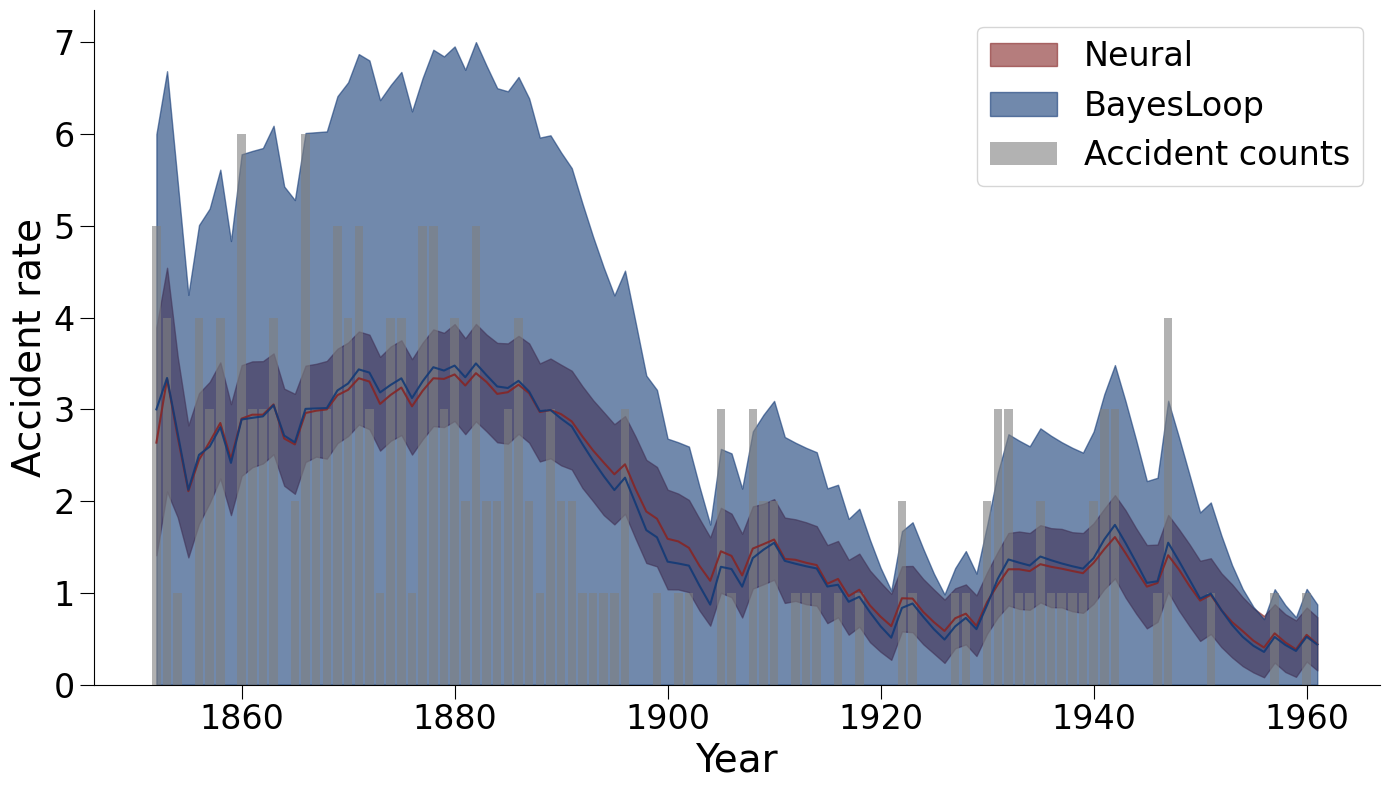

In [35]:
time = coal_mining_data["year"]
plt.figure(figsize=(14, 8))
plt.plot(time, post_mean, alpha=0.9, color=NEURAL_COLOR)
plt.fill_between(
    time,
    net_post_means + net_post_stds,
    net_post_means - net_post_stds,
    alpha=0.6,
    label="Neural",
    edgecolor="none",
    color=NEURAL_COLOR
)

plt.plot(time, bl_post_means, alpha=0.9, color=COMPARISON_COLOR)
plt.fill_between(
    time,
    bl_post_means + bl_post_stds,
    bl_post_means - bl_post_stds,
    alpha=0.6,
    label='BayesLoop',
    edgecolor="none",
    color=COMPARISON_COLOR
)

plt.bar(
    time,
    coal_mining_data["disasters"],
    align="center",
    facecolor="gray",
    alpha=0.6,
    label="Accident counts",
)

plt.ylabel("Accident rate", fontsize=28)
plt.xlabel("Year", fontsize=28)
plt.tick_params(axis="both", which="major", length=10, labelsize=24)

plt.legend(fontsize=24)
sns.despine()
plt.tight_layout()

plt.savefig('../plots/coal_mining_benchmark.png', dpi=300)